# Exploratory Data Analysis, Credit Card Fraud Detection

### This notebook is based on [this blogpost](https://www.toptal.com/machine-learning/generative-adversarial-networks) and its [github repo](https://github.com/codyznash/GANs_for_Credit_Card_Data).

Dataset: `creditcard.csv` was downloaded from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud/data).

### Dataset

**Content**

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. **Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.**

**Inspiration**

Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). **Confusion matrix accuracy is not meaningful for unbalanced classification.**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load libraries and check memory
import psutil ; print(list(psutil.virtual_memory())[0:2])

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import numpy as np
import os
import pandas as pd
import pickle
import xgboost as xgb

import gc
gc.collect()
print(list(psutil.virtual_memory())[0:2])

[17179869184L, 7026372608L]
[17179869184L, 6962651136L]


In [3]:
data = pd.read_csv("./creditcard.csv")
print(data.shape)
print(data.columns)
data.head(3)

(284807, 31)
Index([u'Time', u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9',
       u'V10', u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18',
       u'V19', u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27',
       u'V28', u'Amount', u'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
# data columns will be all other columns except class
label_cols = ['Class']
data_cols = list(data.columns[ data.columns != 'Class' ])

print(data_cols)
print('\n# of data columns: ',len(data_cols))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
('\n# of data columns: ', 30)


Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [5]:
data.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

In [6]:
# Total nulls in dataset (sum over rows, then over columns)

data.isnull().sum().sum()

0

In [7]:
# Duplicates? Yes

normal_duplicates = sum( data.loc[ data.Class==0 ].duplicated() )
fraud_duplicates = sum( data.loc[ data.Class==1 ].duplicated() )
total_duplicates = normal_duplicates + fraud_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Fraud duplicates', fraud_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(data) )

('Normal duplicates', 1062)
('Fraud duplicates', 19)
('Total duplicates', 1081)
('Fraction duplicated', 0)


In [8]:
# 'Time' is seconds from first transaction in set
# 48 hours worth of data
# Let's convert time to time of day, in hours
print( 'Last time value: {:.2f}'.format( data['Time'].max() / 3600. ) )

data['Time'] = ( data['Time'].values / 3600. ) % 24

Last time value: 48.00


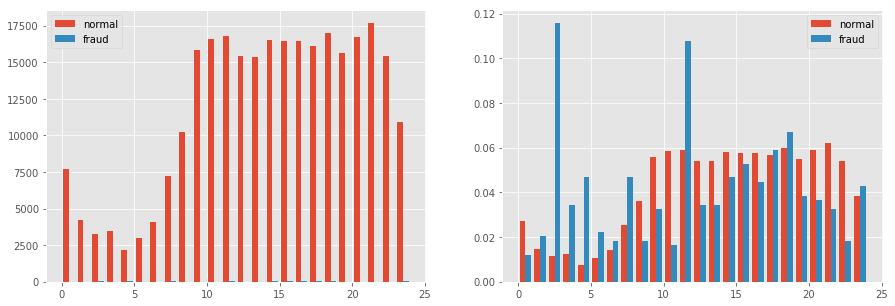

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist([data.loc[data['Class']==0, 'Time'], 
          data.loc[data['Class']==1, 'Time']],
          #density=True, 
         label=['normal','fraud'], 
         bins=np.linspace(0,24,25))
plt.legend()

plt.subplot(1, 2, 2)
plt.hist([data.loc[data['Class']==0, 'Time'], 
          data.loc[data['Class']==1, 'Time']],
          density=True, 
         label=['normal','fraud'], 
         bins=np.linspace(0,24,25))
plt.legend()
plt.show()

# Looks like normal transactions have a bias towards 8am to midnight
# Fraud has spikes at 2-3am and noon

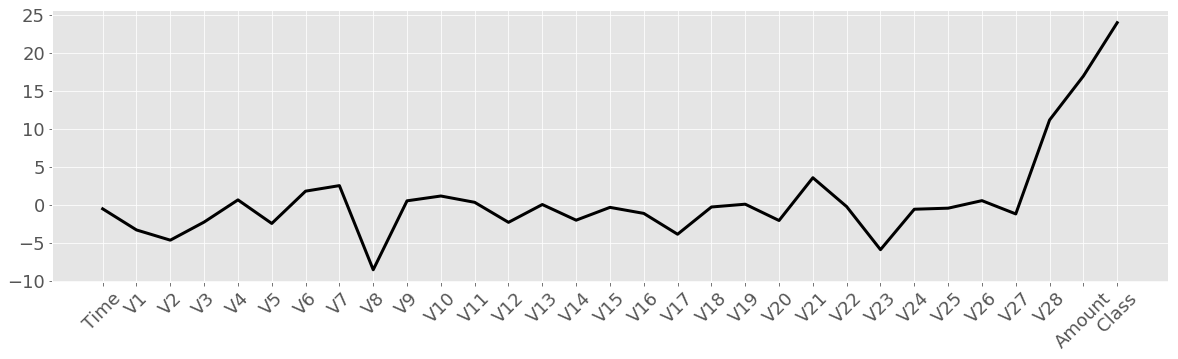

In [10]:
# several columns heavily skewed, 'Amount' the highest (besides Class)
plt.figure(figsize=(20, 5))
plt.plot(data.skew(), c='k', lw=3)
plt.xticks(size=18, rotation=45)
plt.yticks(size=18)
plt.show()

In [11]:
# Minimum 'Amount' is 0
# 0's account for 0.6% of the data set

print(data['Amount'].min())
print(np.sum( data['Amount']==0 ))
print(np.sum( data['Amount']==0 ) / len(data))

0.0
1825
0


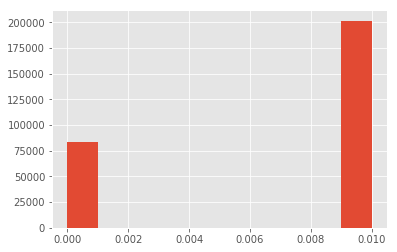

In [12]:
# Looks like all 'Amount' values are rounded to the hundredths (0.01) place
data['Amount'].mod(0.01).hist()

In [13]:
# Some values are much more frequent than others
# 0.00 comes in 12th in the list

print(data.Amount.value_counts().head(15))

1.00     13688
1.98      6044
0.89      4872
9.99      4747
15.00     3280
0.76      2998
10.00     2950
1.29      2892
1.79      2623
0.99      2304
20.00     2002
0.00      1825
8.99      1811
11.50     1741
4.49      1579
Name: Amount, dtype: int64


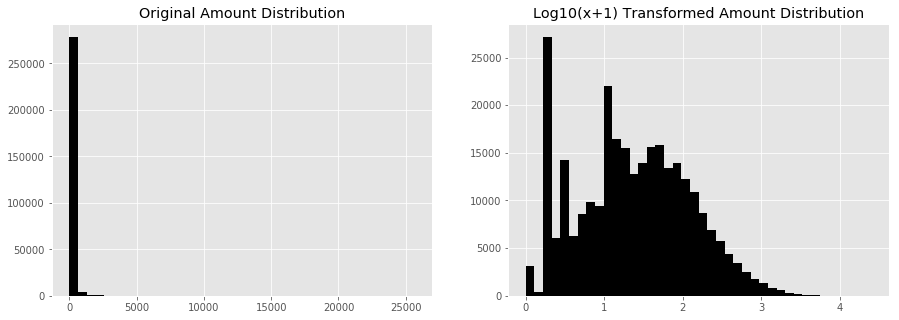

In [14]:
# Log transform amount values to give more normal distribution
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(data['Amount'], bins=40, color='k')
plt.title('Original Amount Distribution')

plt.subplot(1,2,2)
d0 = np.log10( data['Amount'].values + 1 )
# d0 = np.log1p( data['Amount'].values ) / np.log(10)
plt.hist(d0, bins=40, color='k')
plt.title('Log10(x+1) Transformed Amount Distribution')
plt.show()

In [15]:
# Use log transformed data
#data['Amount_orig'] = data['Amount']
data['Amount'] = d0

In [16]:
# Center and scale all data, only using the middle 99.8%, so outliers don't pull too much.
# First generate the percentile data for each feature

percentiles =  pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.9 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )

percentile_means = \
    [ [ np.mean( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

percentiles.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
min,0.025833,-16.044343,-15.126221,-9.870326,-4.163262,-9.408512,-5.290163,-9.365179,-13.102174,-3.305247,...,-6.621889,-5.490204,-3.119845,-5.452756,-2.001248,-2.403083,-1.276676,-3.823857,-2.629030,0.000000
max,23.965278,2.344685,7.852129,3.387393,6.235906,8.074611,6.164944,7.972745,6.135087,5.960836,...,5.809376,7.879007,2.260348,4.759942,1.246819,1.873743,2.251097,2.607462,2.095818,3.477266
mean,14.543063,0.020195,0.012756,0.011923,-0.003827,0.002532,-0.000677,0.001153,0.011022,-0.002363,...,0.002214,-0.002930,0.001083,0.002081,0.000089,0.000504,-0.001117,0.001314,-0.000914,1.375513
stdev,5.827070,1.814661,1.429787,1.419404,1.383725,1.208541,1.263637,1.018486,0.956445,1.064801,...,0.595668,0.550113,0.704365,0.433626,0.596816,0.505554,0.474011,0.330955,0.223416,0.710045


In [17]:
# Center and scale the data using the percentile data we just generated
data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]

In [18]:
# # Or we can center and scale using all of the data
# from sklearn.preprocessing import StandardScaler
# data[data_cols] = StandardScaler().fit_transform(data[data_cols])

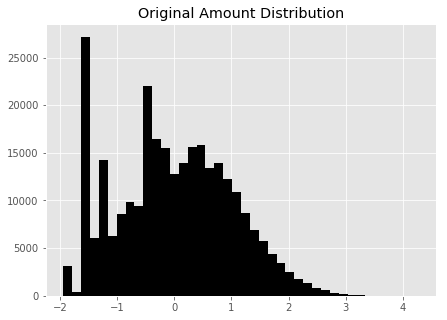

In [19]:
# Log transform amount values to give more normal distribution
plt.figure(figsize=(7,5))

plt.hist(data['Amount'], bins=40, color='k')
plt.title('Original Amount Distribution')
plt.show()

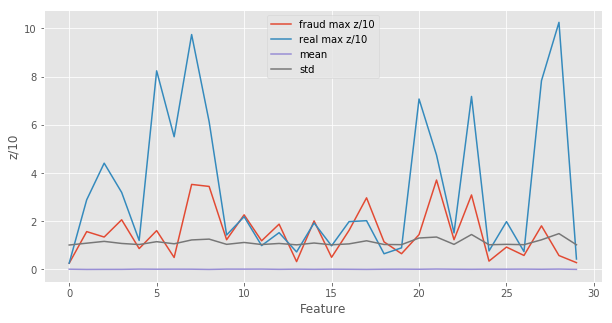

In [20]:
# There are outliers, 50-100 stdevs away from mean in several columns
plt.figure(figsize=(10, 5))
plot_cols = data_cols
plt.plot( data.loc[ data.Class==1, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10., label='fraud max z/10' )
plt.plot( data.loc[ data.Class==0, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10., label='real max z/10' )
plt.plot( data[ plot_cols ].mean().values, label='mean' )
# plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
plt.plot( data[ plot_cols ].std().values, label='std' )
plt.xlabel('Feature')
plt.ylabel('z/10')
plt.legend()

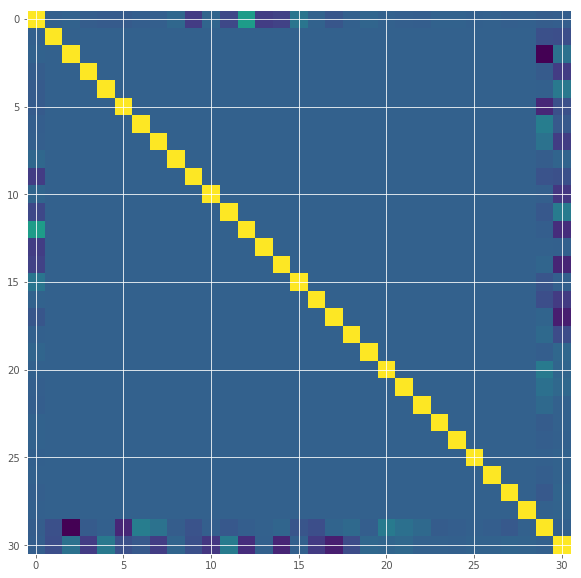

In [21]:
# Check Correlations
# Note no correlations among PCA transformed columns, as expected
corr0 = data.corr()
plt.figure(figsize=(10, 10))
plt.imshow(corr0)
plt.show()

In [22]:
# Looking at correlation values

# np.round(corr0[['Time','Amount','Class']],2)
# plt.imshow( np.round(corr0[['Time','Amount','Class']],2) ) ;
# corr0[data_cols]
# np.round(corr0[data_cols],1)
# np.round(corr0[data_cols],1)

## Data Distributions by Feature and Class

/Users/khosseini/anaconda3/envs/py27_quipp/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


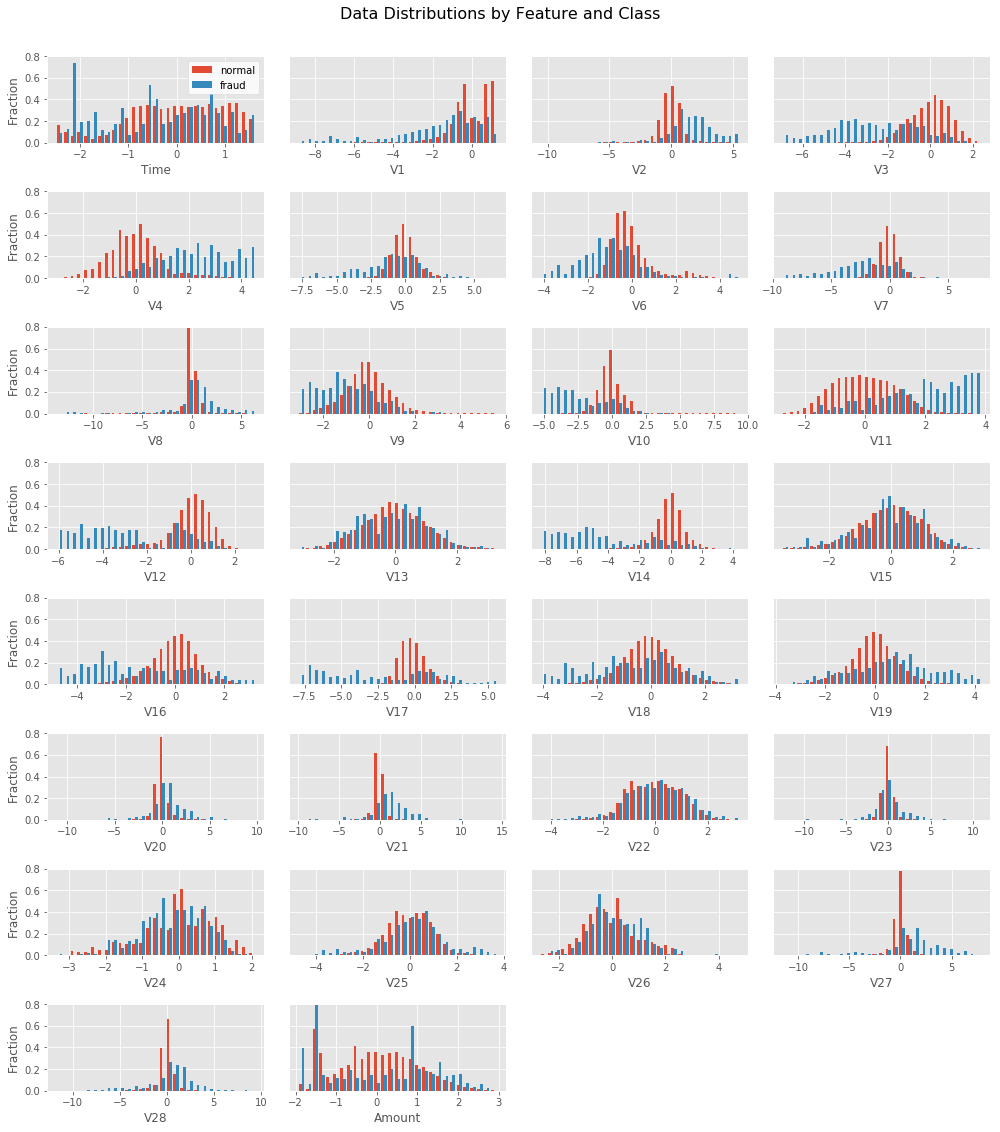

In [23]:
# Plot the data by each feature
axarr = [[]]*len(data_cols)
columns = 4.
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data.Class == 0, col ], data.loc[ data.Class == 1, col ] ], label=['normal','fraud'], 
                    bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30 ),
                    density=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/Engineered_Data_Distributions.png')
plt.show()

In [24]:
# Save engineered dataset for use in analysis
# Save as pickle for faster reload
pickle.dump(data, open('./credicard.engineered.pkl','wb'))

In [25]:
# # Save as csv for human readability - much slower save
# data.to_csv(os.path.curdir + 'credicard.engineered.csv.zip')

In [26]:
# Load engineered dataset from EDA section
data = pickle.load(open('./credicard.engineered.pkl','rb'))

# data columns will be all other columns except class
data_cols = list(data.columns[ data.columns != 'Class' ])
label_cols = ['Class']

print(data_cols)
print('# of data columns: ',len(data_cols))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
('# of data columns: ', 30)


In [27]:
# Put columns in order of importance for xgboost fraud detection (from that section)

# sorted_cols = ['V14', 'V4', 'V12', 'V10', 'V26', 'V17', 'Amount', 'V7', 'V21', 'V28', 'V20', 'V3', 'V18', 'V8', 'V13', 'V22', 'V16', 'V11', 'V19', 'V27', 'V5', 'V6', 'V25', 'V15', 'V24', 'V9', 'V1', 'V2', 'V23', 'Class']
# sorted_cols = ['V14', 'V4', 'V12', 'V10', 'Amount', 'V26', 'V17', 'Time', 'V7', 'V28', 'V21', 'V19', 'V8', 'V3', 'V22', 'V20', 'V25', 'V11', 'V6', 'V16', 'V27', 'V5', 'V18', 'V9', 'V1', 'V2', 'V15', 'V23', 'V24', 'V13', 'Class']
sorted_cols = ['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']

data = data[ sorted_cols ].copy()

In [28]:
# Add KMeans generated classes to fraud data - see classification section for more details on this
import sklearn.cluster as cluster

train = data.loc[ data['Class']==1 ].copy()

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train[ data_cols ])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels

   count
0    357
1    135


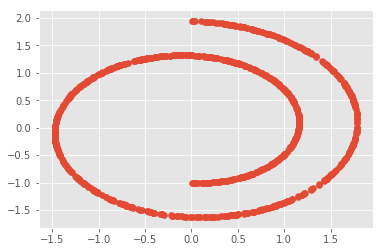

In [29]:
# Function to create toy spiral dataset (looks like swiss roll)
def create_toy_spiral_df( n, seed=0):
    np.random.seed(seed)
    toy = np.array([ [ (i/10+1) * np.sin(i), -(i/10+1) * np.cos(i) ] for i in np.random.uniform(0,3*np.pi,size=n) ])
    toy = pd.DataFrame( toy, columns=[ ['v'+str(i+1) for i in range(2)] ])
    return toy

toy = create_toy_spiral_df(1000) 
plt.scatter( toy['v1'].values, toy['v2'].values )

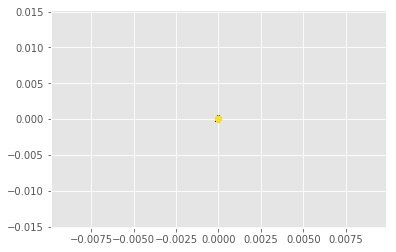

In [30]:
# Function to create toy dataset of multiple groups of normal distributions in n dimensions
def create_toy_df( n, n_dim, n_classes, seed=0):
    toy = pd.DataFrame(columns=[ ['v'+str(i+1) for i in range(n_dim)] + ['Class'] ])
    toy_cols = toy.columns
    np.random.seed(seed)
    for class0 in range(n_classes):
        center0s = np.random.randint(-10,10,size=n_dim)/10
        var0s = np.random.randint(1,3,size=n_dim)/10
        temp = np.array([[class0]]*n)
        for dim0 in range(n_dim):
            temp = np.hstack( [np.random.normal(center0s[dim0],var0s[dim0],n).reshape(-1,1), temp] )
        toy = pd.concat([toy,pd.DataFrame(temp,columns=toy_cols)],axis=0).reset_index(drop=True)
    return toy

toy = create_toy_df(n=1000,n_dim=2,n_classes=2,seed=0)
plt.scatter(toy[toy.columns[0]].values,toy[toy.columns[1]].values,c=toy['Class'].values[:, 0], alpha=0.2)